In [1]:
# coding: utf-8

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from numpy.random import RandomState
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,CuDNNLSTM,Dropout,Activation,Bidirectional
from keras.layers import Conv1D, Convolution1D, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau  #学习率自动变化
from keras.callbacks import EarlyStopping
from utils.attention import Attention_layer

#使用GPU
import keras.backend.tensorflow_backend as KTF 
KTF.set_session(tf.Session(config=tf.ConfigProto(device_count={'gpu':0})))

import time
import os
import argparse
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

#matplotlib inline
plt.rcParams['figure.figsize'] = 16,6
plt.rcParams['xtick.color'] = 'w'  
plt.rcParams['ytick.color'] = 'w'  
mpl.style.use('ggplot')
font1 = {'family' : 'Times New Roman' , 'weight' : 'normal','size': 23}
font2 = {'family' : 'Times New Roman' , 'weight' : 'normal','size': 18}

D:\Programs\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#主要的超参数
"""
parser = argparse.ArgumentParser(description='1dcnn+blstm+fc')
parser.add_argument('--seed', default=0, type=int, help='random seed')
parser.add_argument('--sequence_length', default=110, type=int, help='sequence_length')
parser.add_argument('--lstm1', default=300, type=int, help='lstm1')
parser.add_argument('--lstm2', default=300, type=int, help='lstm2')
parser.add_argument('--dense1', default=50, type=int, help='dense1')
parser.add_argument('--dropout1', default=0.4, type=float, help='dropout1')
parser.add_argument('--dropout2', default=0.4, type=float, help='dropout2')
parser.add_argument('--epochs', default=1, type=int, help='epochs')
parser.add_argument('--batch_size', default=100, type=int, help='batch_size')
parser.add_argument('--lr', default=2e-2, type=float, help='learning rate')
parser.add_argument('--weight_decay', default=1e-4, type=float, help='weight_decay')
parser.add_argument('--test', default='0', type=str, help='input model file name, then it will be tested')
parser.add_argument('--filters1', default=16, type=int, help='filters1')
parser.add_argument('--filters2', default=32, type=int, help='filters2')

args = parser.parse_args()
print(args)
"""
args_seed = 0
args_sequence_length = 110
args_lstm1 = 300
args_lstm2 = 300
args_dense1 = 50
args_dropout1 = 0.4
args_dropout2 = 0.4
args_epochs = 30
args_batch_size = 100
args_lr = 2e-2
args_weight_decay = 1e-4
args_test = '0'
args_filters1 = 16
args_filters2 = 32

# seed
np.random.seed(args_seed)
tf.set_random_seed(args_seed)

# ## 数据导入和处理
train_df_path = r'../data/processed_data/train_df.csv'
test_df_path = r'../data/processed_data/test_df.csv'
data_master_thesis_path = r'../../data/data_master_thesis'

train_df = pd.read_csv(train_df_path,index_col=0) #第一列作为index
test_df = pd.read_csv(test_df_path,index_col=0)

#print("train_df shape: {}".format(train_df.shape))
#print("test_df shape: {}".format(test_df.shape))


# ## 定义X_train, y_train, X_test, y_train


X_train = train_df.iloc[:,5:26]
y_train = train_df.iloc[:,-2]

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = test_df.iloc[:,5:26]
y_test = test_df.iloc[:,-1]#注意，test_df中RUL列是最后一列，
                           #但是，测试集的RUL不是test_df的RUL对应的列

X_test = np.array(X_test)
y_test = np.array(y_test)

#print("X_train.shape: {}, y_train.shape: {}, X_test.shape: {}, y_test.shape: {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

In [3]:
# ## 采用时间窗分割的方式改变数据的维度


# 将数据格式变为(样本循环次数, 时间窗大小：30, 特征数)
def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(
            range(0, num_elements - seq_length), range(seq_length,
                                                       num_elements)):
        yield data_array[start:stop, :]


# 选择特征列
sensor_cols = ['s' + str(i) for i in range(1, 22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# seq_array为用上函数生成的数组，其形状为(15631, 30, 25)
seq_gen = (list(
    gen_sequence(train_df[train_df['id'] == id], args_sequence_length,
                 sequence_cols)) for id in train_df['id'].unique())
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)


# 对应数据格式生成标签
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]


# 标签的形状为(15631, 1)
label_gen = [
    gen_labels(train_df[train_df['id'] == id], args_sequence_length, ['RUL'])
    for id in train_df['id'].unique()
]
label_array = np.concatenate(label_gen).astype(np.float32)

# 生成test数据的最后一个序列，形状为(93, 50, 25)，不足100是因为有些测试集小于50
seq_array_test_last = [
    test_df[test_df['id'] == id][sequence_cols].values[-args_sequence_length:]
    for id in test_df['id'].unique()
    if len(test_df[test_df['id'] == id]) >= args_sequence_length
]
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# 对应生成test的label，形状为(93, 1)
y_mask = [
    len(test_df[test_df['id'] == id]) >= args_sequence_length
    for id in test_df['id'].unique()
]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(
    label_array_test_last.shape[0], 1).astype(np.float32)

#nb_features = seq_array.shape[2]
# nb_features == 25
#nb_out = label_array.shape[1]
# nb_out ==1

# print("seq_array shape: {}".format(seq_array.shape))
# print("label_array shape: {}".format(label_array.shape))
# print("seq_array_test_last shape: {}".format(seq_array_test_last.shape))
# print("label_array_test_last shape: {}".format(label_array_test_last.shape))

X_train = seq_array
y_train = label_array
X_test = seq_array_test_last
y_test = label_array_test_last

print("X_train.shape: {}, y_train.shape: {}, X_test.shape: {}, y_test.shape: {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train.shape: (9631, 110, 25), y_train.shape: (9631, 1), X_test.shape: (67, 110, 25), y_test.shape: (67, 1)


In [6]:
# 现在X_train, y_train, X_test, y_test已经准备好了
def get_rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def model_train_visualization(path, logname, model):
    # model architechture
    name = logname.split('.')[0] + '.png'
    path = path
    path = os.path.join(path, name)
    keras.utils.plot_model(model, to_file=path)

    # tensorboard
    

def get_model():
    model = Sequential()
    model.add(Conv1D(args_filters1, 1, activation='relu', input_shape=(args_sequence_length, 25)))
    model.add(MaxPooling1D(1))
    model.add(Conv1D(args_filters2, 1, activation='relu', input_shape=(args_sequence_length, 25)))
    model.add(MaxPooling1D(1))
    model.add(
        Bidirectional(CuDNNLSTM(
            args_lstm1,
            input_shape=(X_train.shape[1], X_train.shape[2]),
            return_sequences=True)))
    model.add(Activation('tanh'))
    model.add(Dropout(args_dropout1))

    #model.add(Attention_layer())
    model.add(Bidirectional(CuDNNLSTM(args_lstm2, return_sequences=False)))
    model.add(Activation('tanh'))
    model.add(Dropout(args_dropout2))

    model.add(Dense(args_dense1))
    model.add(Activation('tanh'))  #
    model.add(Dropout(args_dropout2))

    model.add(Dense(1))
    #model.add(Activation('linear'))

    # sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    adam = keras.optimizers.Adam(lr=args_lr, beta_1=0.9, beta_2=0.999,
                                 epsilon=None, decay=args_weight_decay, amsgrad=False)
    model.compile(loss='mse', optimizer=adam)
    return model
def main():
    ####模型构建#################################

    # 我们可以看到LSTM（）层必须指定输入的形状。而且每个LSTM层的输入必须是三维的。这输入的三个维度是：
    #
    # - samples。一个序列是一个样本。批次由一个或多个样本组成。
    #
    # - timesteps。一个时间步代表样本中的一个观察点。timesteps可以理解为循环神经网络认为每个输入数据与前多少个连续输入的数据有联系
    #
    # - features。一个特征是在一个时间步长的观察得到的。
    # - 学习率。
    model = get_model()
    # 模型训练
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=15, verbose=1, mode='auto')
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
    
    ## tensorboard logging
    tb_callback = keras.callbacks.TensorBoard(log_dir = os.path.join(data_master_thesis_path, 'tensorboard'),
                                              histogram_freq=1,
                                              write_graph=True,
                                              write_images=True)
    start_time = time.clock()
    history = model.fit(
        X_train,
        y_train,
        epochs=args_epochs,
        batch_size=args_batch_size,
        validation_split=0.3,
        callbacks=[reduce_lr, early_stopping, tb_callback],
        verbose=2,
        shuffle=True)
    end_time = time.clock()
    print("Training time: {:.4} minutes".format((end_time - start_time) / 60))

    # 模型评估
    y_pred = model.predict(X_test)

    rmse = get_rmse(y_pred, y_test)

    t = time.localtime()
    ft = "%Y%m%d%H%M%S"
    datetime = time.strftime(ft, t)
    model_name = str(int(rmse*100)) + datetime + '.h5'
    model_path = os.path.join(os.path.join(data_master_thesis_path, 'model_saved'), model_name)
    print(type(history.history['loss']))

    if rmse < 10:
        model.save(model_path)

    log = np.concatenate((np.array(history.history['loss'])[:, np.newaxis],
                           np.array(history.history['val_loss'])[:,np.newaxis]), axis=1)
    logpath = str(int(rmse*100)) + datetime + '.txt'
    logpath = os.path.join('../model_saved/logs', logpath)
    np.savetxt(logpath, log)
    with open(logpath, 'a', encoding='utf-8') as f:
        #f.write(model.get_config()) # TypeError: write() argument must be str, not dict
        print(model.get_config(), file=f)
        #f.write(str(args))
        model.summary(print_fn=lambda x: f.write(x + '\n')) # it is the easist way
                                                            # to log model.summary()
        '''
        config = model.get_config()
        model = Model.from_config(config)
        # or, for Sequential:
        model = Sequential.from_config(config)
        '''

        plt.figure(figsize=(20, 10))
        plt.plot(history.history['loss'], 'o-', color='red', label='train')
        plt.plot(history.history['val_loss'], 'o-', color='blue', label='val')
        plt.legend(prop=font2)
        plt.xlabel('epoch', font1)
        plt.ylabel('loss', font1)
        figname = str(int(rmse * 100)) + datetime + '.png'
        figpath = os.path.join('../model_saved/images', figname)
        plt.savefig(figpath)
        #plt.show()
    # model architechture
    arch_name = str(int(rmse*100)) + datetime + '.png'
    arch_path = '../model_saved/model_architechture'
    path = os.path.join(arch_path, arch_name)
    keras.utils.plot_model(model, to_file=path)
    
    print("train loss:")
    print(history.history['loss'])
    print("val loss:")
    print(history.history['val_loss'])
    print()
    print(model.summary())
    print()
    #print(args)
    print("model_name: ", model_name)
    print("time_step: {}".format(args_sequence_length))
    print("number of filter is 16,32,64")
    print("length of filter is 1")
    print("unit_lstm1: {}".format(args_lstm1))
    print("unit_lstm2: {}".format(args_lstm2))
    print("dense1: {}".format(args_dense1))
    print("dropout_rate1 :{}".format(args_dropout1))
    print("dropout_rate2 :{}".format(args_dropout2))
    print("set epoch_num :{}".format(args_epochs))
    print("batch_size_num :{}".format(args_batch_size))
    print("*****结果***************************")
    print("Train rmse: {}".format(np.sqrt(history.history['loss'][-1])))
    print("Validation rmse: {}".format(np.sqrt(history.history['val_loss'][-1])))
    print("Test rmse: {}".format(rmse))
    print("*********************************************************")


def test(model_name):
    model_path = os.path.join('../model_saved', model_name)
    model = keras.models.load_model(model_path)
    y_pred = model.predict(X_test)
    rmse = get_rmse(y_pred, y_test)
    print('rmse: {:.2f}'.format(rmse))

Train on 6741 samples, validate on 2890 samples
Epoch 1/10
 - 43s - loss: 1933.0188 - val_loss: 1828.5157
Epoch 2/10
 - 40s - loss: 1398.4787 - val_loss: 1809.7807
Epoch 3/10
 - 40s - loss: 1397.5574 - val_loss: 1830.1019
Epoch 4/10
 - 44s - loss: 1398.4335 - val_loss: 1808.0125
Epoch 5/10
 - 42s - loss: 1396.2579 - val_loss: 1819.2555
Epoch 6/10
 - 45s - loss: 1404.8916 - val_loss: 1825.6324
Epoch 7/10
 - 47s - loss: 1401.3115 - val_loss: 1811.9481
Epoch 8/10
 - 44s - loss: 1392.7118 - val_loss: 1834.0734
Epoch 9/10
 - 42s - loss: 1404.5909 - val_loss: 1804.2018
Epoch 10/10
 - 40s - loss: 1398.0329 - val_loss: 1803.7356
Training time: 19.88 minutes
<class 'list'>
train loss:
[1933.0187779126509, 1398.4787044799605, 1397.5573700046243, 1398.4334734543338, 1396.2578654134331, 1404.8915916027504, 1401.311471755454, 1392.711814772851, 1404.5908951192737, 1398.0328872017435]
val loss:
[1828.5157124344453, 1809.7807338411008, 1830.1018725332503, 1808.0125014361213, 1819.255488095399, 1825.6

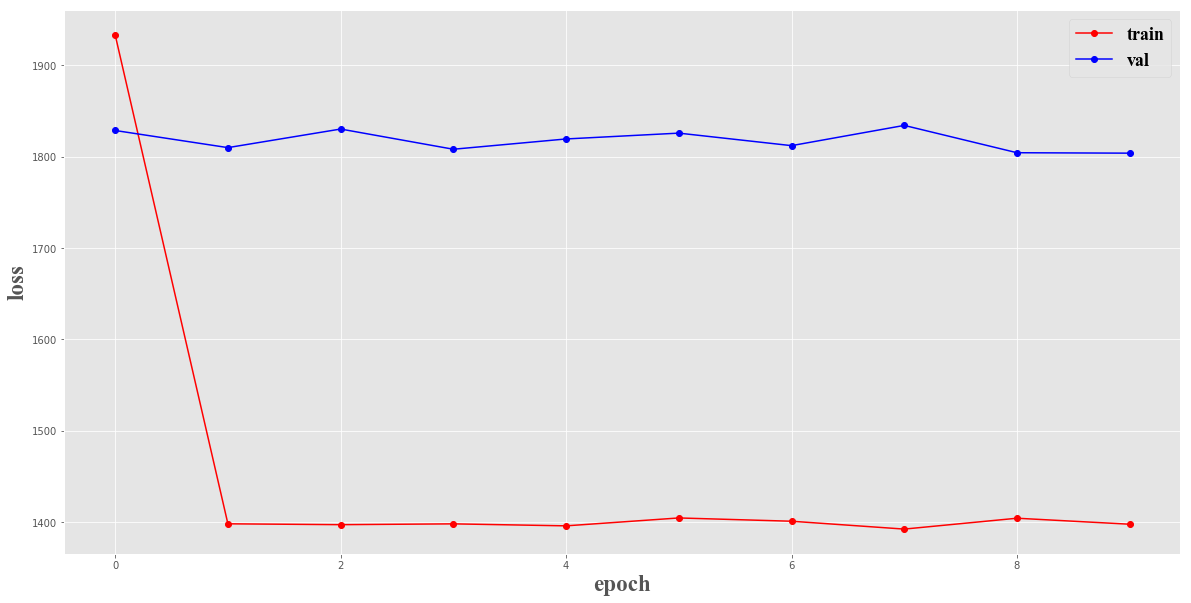

In [7]:
if __name__ == '__main__':
    if args_test == '0':
        main()
    else:
        test(args_test)